In [56]:
import pandas as pd
import numpy as np
import random
import json
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

from bayes_opt import BayesianOptimization
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

SEED = 42

random.seed(SEED)
np.random.seed(SEED)

In [57]:
df = pd.read_csv('./df_clean.csv', index_col=0)

df.head()

,category,amt,gender,is_fraud,transaction_month,transaction_day,transaction_hour,transaction_day_of_week,transaction_is_weekend,age,time_category
0,misc_net,4.97,F,0,1,1,0,1,0,30,midnight
1,grocery_pos,107.23,F,0,1,1,0,1,0,40,midnight
2,entertainment,220.11,M,0,1,1,0,1,0,56,midnight
3,gas_transport,45.00,M,0,1,1,0,1,0,51,midnight
4,misc_pos,41.96,M,0,1,1,0,1,0,32,midnight


In [58]:
le = LabelEncoder()

df['category'] = le.fit_transform(df['category'])
df['gender'] = le.fit_transform(df['gender'])
df['time_category'] = le.fit_transform(df['time_category'])

df

,category,amt,gender,is_fraud,transaction_month,transaction_day,transaction_hour,transaction_day_of_week,transaction_is_weekend,age,time_category
0,8,4.97,0,0,1,1,0,1,0,30,2
1,4,107.23,0,0,1,1,0,1,0,40,2
2,0,220.11,1,0,1,1,0,1,0,56,2
3,2,45.00,1,0,1,1,0,1,0,51,2
4,9,41.96,1,0,1,1,0,1,0,32,2
...,...,...,...,...,...,...,...,...,...,...,...
1296670,0,15.56,1,0,6,21,12,6,1,58,0
1296671,1,51.70,1,0,6,21,12,6,1,40,0
1296672,1,105.93,1,0,6,21,12,6,1,52,0
1296673,1,74.90,1,0,6,21,12,6,1,39,0


In [59]:
# Pisahkan X (fitur) dan y (target)
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

# Split data menjadi training dan testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)

In [60]:
scaler = StandardScaler()
numerical_features = ['amt','age']

In [61]:
# SMOTE Oversampling
smote = SMOTE(random_state=SEED)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Scaling setelah oversampling (fit pada data training)
X_train_smote[numerical_features] = scaler.fit_transform(X_train_smote[numerical_features])

In [62]:
# ADASYN Oversampling
adasyn = ADASYN(random_state=SEED)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

# Scaling setelah oversampling (fit pada data training)
X_train_adasyn[numerical_features] = scaler.fit_transform(X_train_adasyn[numerical_features])

In [63]:
# Scaling data test (transform tanpa fit ulang)
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# scaling untuk data train tanpa oversampling
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])

In [64]:
def build_train_model(method, model_name, params):
    model = None
    if model_name == 'adaboost':
        model = AdaBoostClassifier(n_estimators=int(params['n_estimators']), learning_rate=params['learning_rate'])
    elif model_name == 'random_forest':
        model = RandomForestClassifier(n_estimators=int(params['n_estimators']), max_depth=int(params['max_depth']))
    elif model_name == 'decision_tree':
        model = DecisionTreeClassifier(max_depth=int(params['max_depth']), min_samples_split=int(params['min_samples_split']))
    elif model_name == 'logistic_regression':
        model = LogisticRegression(C=params['C'], solver='liblinear')
    else:
        raise ValueError("Unknown model")

    # chose training set
    X_resampled, y_resampled = None, None
    if method is None:
        X_resampled, y_resampled = X_train, y_train
    elif method == 'smote':
        X_resampled, y_resampled = X_train_smote, y_train_smote
    elif method == 'adasyn':
        X_resampled, y_resampled = X_train_adasyn, y_train_adasyn
    else:
        raise ValueError("Unknown method")

    # perform training
    model.fit(X_resampled, y_resampled)
    return model
    

In [65]:
# Function to load the best parameters from a JSON file
def load_best_params_from_json(filename="best_params.json"):
    with open(filename, 'r') as json_file:
        best_params = json.load(json_file)
    return best_params

In [66]:
def save_report_to_json(cl_report, filename="cl_report.json"):
    with open(filename, 'w') as json_file:
        json.dump(cl_report, json_file, indent=4)
    print(f"Classification Report saved to {filename}")

In [67]:
def save_model_to_file(model, filename="model.pkl"):
    with open(filename,'wb') as f:
        pickle.dump(model,f)

In [68]:
MODEL_DICT = {
    'adaboost': {},
    'random_forest': {},
    'decision_tree': {},
    'logistic_regression': {},
}

In [69]:
MODEL_DICT['adaboost']['params'] = {}
MODEL_DICT['adaboost']['params']['no_oversampling'] = load_best_params_from_json("best_params_ada.json")
MODEL_DICT['adaboost']['params']['smote'] = load_best_params_from_json("best_params_ada_smote.json")
MODEL_DICT['adaboost']['params']['adasyn'] = load_best_params_from_json("best_params_ada_adasyn.json")

MODEL_DICT['random_forest']['params'] = {}
MODEL_DICT['random_forest']['params']['no_oversampling'] = load_best_params_from_json("best_params_rf.json")
MODEL_DICT['random_forest']['params']['smote'] = load_best_params_from_json("best_params_rf_smote.json")
MODEL_DICT['random_forest']['params']['adasyn'] = load_best_params_from_json("best_params_rf_adasyn.json")

MODEL_DICT['decision_tree']['params'] = {}
MODEL_DICT['decision_tree']['params']['no_oversampling'] = load_best_params_from_json("best_params_dt.json")
MODEL_DICT['decision_tree']['params']['smote'] = load_best_params_from_json("best_params_dt_smote.json")
MODEL_DICT['decision_tree']['params']['adasyn'] = load_best_params_from_json("best_params_dt_adasyn.json")

MODEL_DICT['logistic_regression']['params'] = {}
MODEL_DICT['logistic_regression']['params']['no_oversampling'] = load_best_params_from_json("best_params_lr.json")
MODEL_DICT['logistic_regression']['params']['smote'] = load_best_params_from_json("best_params_lr_smote.json")
MODEL_DICT['logistic_regression']['params']['adasyn'] = load_best_params_from_json("best_params_lr_adasyn.json")

for model in MODEL_DICT:
    params = MODEL_DICT[model]['params']
    for method in params:
        best_parameters = params[best]
        print(f"Best parameters for model {model} with {method} ", best_parameters)


Best parameters for model adaboost with no_oversampling  {'learning_rate': 0.988453318227812, 'n_estimators': 320.58962466300795}
Best parameters for model adaboost with smote  {'learning_rate': 0.988453318227812, 'n_estimators': 320.58962466300795}
Best parameters for model adaboost with adasyn  {'learning_rate': 0.988453318227812, 'n_estimators': 320.58962466300795}
Best parameters for model random_forest with no_oversampling  {'max_depth': 30.0, 'n_estimators': 208.93521484970233}
Best parameters for model random_forest with smote  {'max_depth': 30.0, 'n_estimators': 208.93521484970233}
Best parameters for model random_forest with adasyn  {'max_depth': 30.0, 'n_estimators': 208.93521484970233}
Best parameters for model decision_tree with no_oversampling  {'max_depth': 30.0, 'min_samples_split': 8.236309114883682}
Best parameters for model decision_tree with smote  {'max_depth': 30.0, 'min_samples_split': 8.236309114883682}
Best parameters for model decision_tree with adasyn  {'max_d

In [70]:
# build and train each model and oversampling method

for model_name in MODEL_DICT:
    params = MODEL_DICT[model_name]['params']
    MODEL_DICT[model_name]['models'] = {}
    for method in params:
        print(f"Building and training model {model_name} with {method}")
        best_parameters = params[method]
        method_oversampling = None if method == 'no_oversampling' else method
        model = build_train_model(method_oversampling, model_name, best_parameters)
        save_model_to_file(model, f"{model_name}_{method}.pkl")
        MODEL_DICT[model_name]['models'][method] = model

Building and training model adaboost with no_oversampling
Building and training model adaboost with smote
Building and training model adaboost with adasyn
Building and training model random_forest with no_oversampling
Building and training model random_forest with smote
Building and training model random_forest with adasyn
Building and training model decision_tree with no_oversampling
Building and training model decision_tree with smote
Building and training model decision_tree with adasyn
Building and training model logistic_regression with no_oversampling
Building and training model logistic_regression with smote
Building and training model logistic_regression with adasyn


In [71]:
# make predictions

for model_name in MODEL_DICT:
    methods = MODEL_DICT[model_name]['models']
    MODEL_DICT[model_name]['predictions'] = {}
    for method in methods:
        print(f"Making predictions model {model_name} with {method}")
        model = methods[method]
        y_pred = model.predict(X_test)
        MODEL_DICT[model_name]['predictions'][method] = y_pred

Making predictions model adaboost with no_oversampling
Making predictions model adaboost with smote
Making predictions model adaboost with adasyn
Making predictions model random_forest with no_oversampling
Making predictions model random_forest with smote
Making predictions model random_forest with adasyn
Making predictions model decision_tree with no_oversampling
Making predictions model decision_tree with smote
Making predictions model decision_tree with adasyn
Making predictions model logistic_regression with no_oversampling
Making predictions model logistic_regression with smote
Making predictions model logistic_regression with adasyn


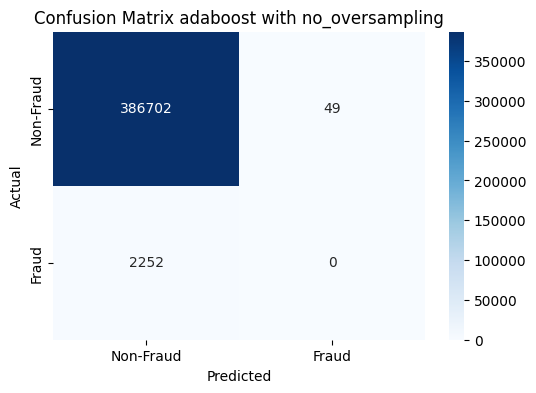

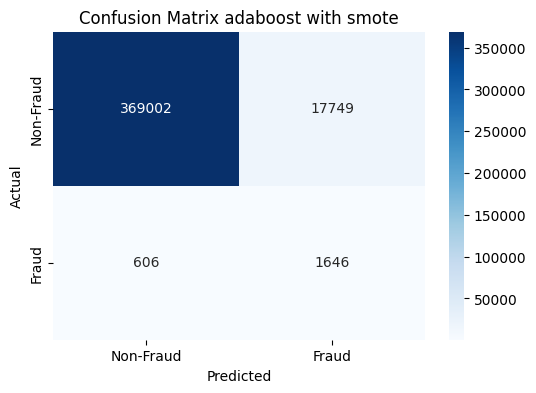

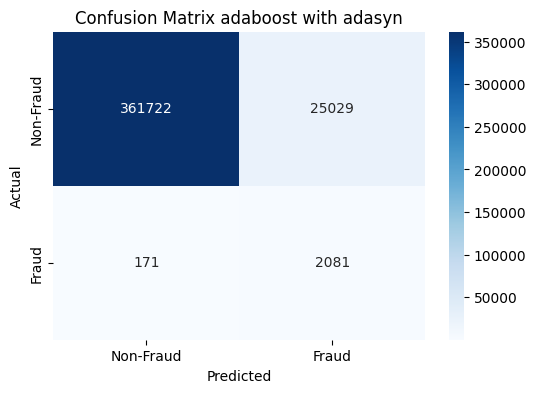

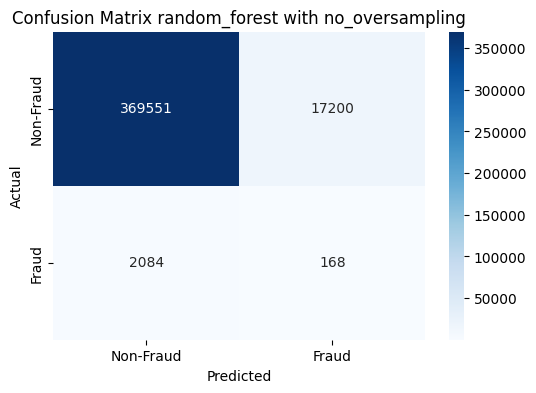

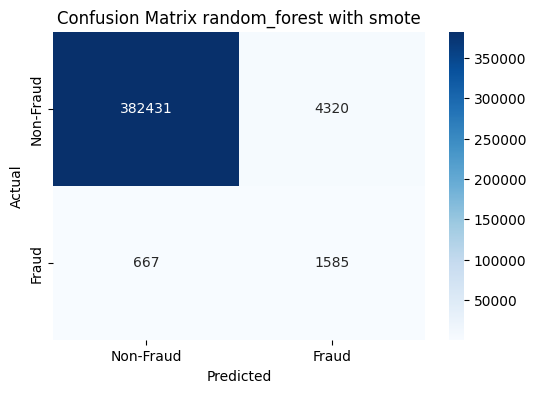

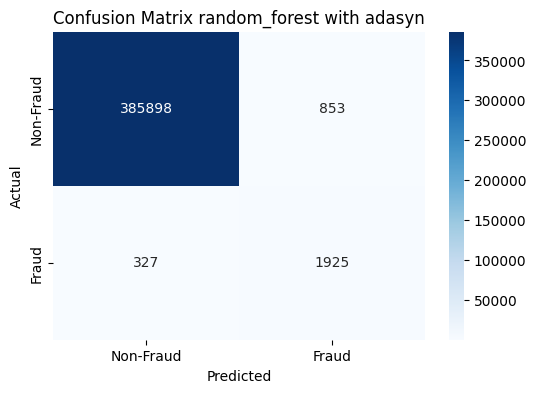

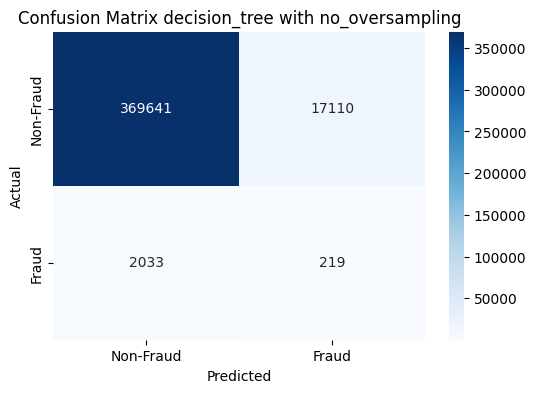

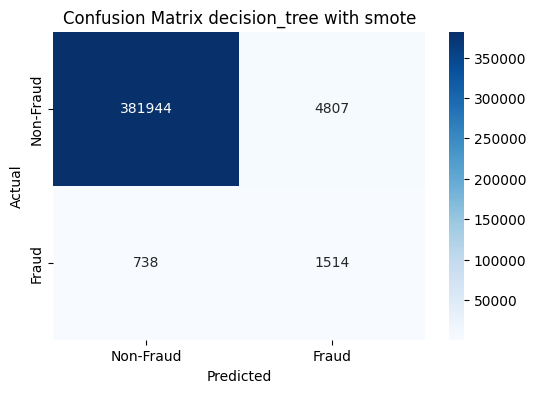

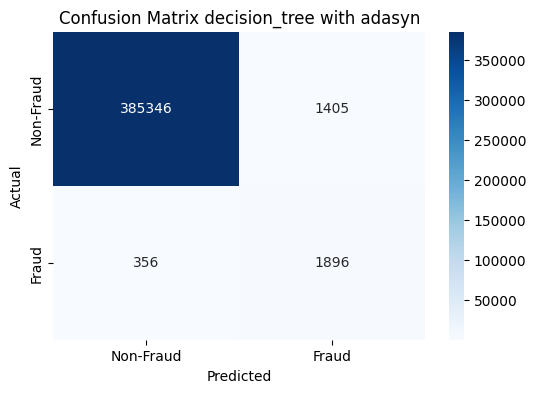

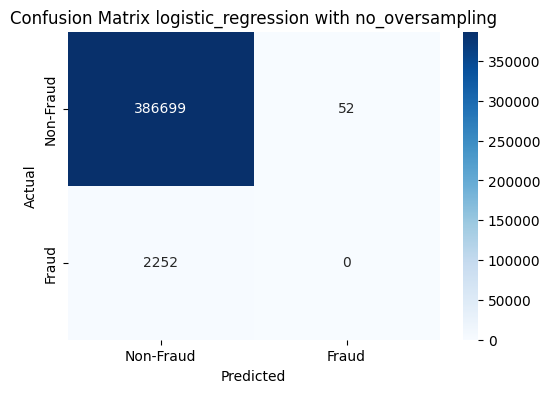

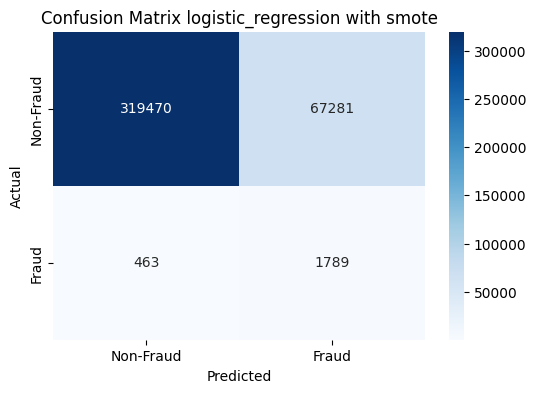

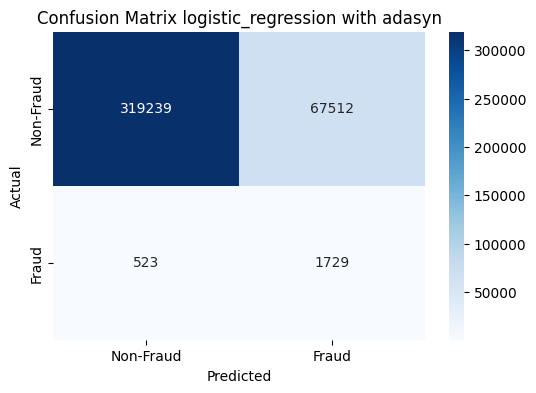

In [72]:
# show confusion matrix
for model_name in MODEL_DICT:
    methods = MODEL_DICT[model_name]['predictions']
    MODEL_DICT[model_name]['confusion_matrix'] = {}
    for method in methods:
        y_pred = methods[method]
        cm = confusion_matrix(y_test, y_pred)
        MODEL_DICT[model_name]['confusion_matrix'][method] = cm

        # Visualisasi Confusion Matrix
        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f"Confusion Matrix {model_name} with {method}")
        plt.savefig(f"confusion_matrix_{model_name}_{method}")
        plt.show()


Classification Report saved to cl_report_adaboost_no_oversampling.json


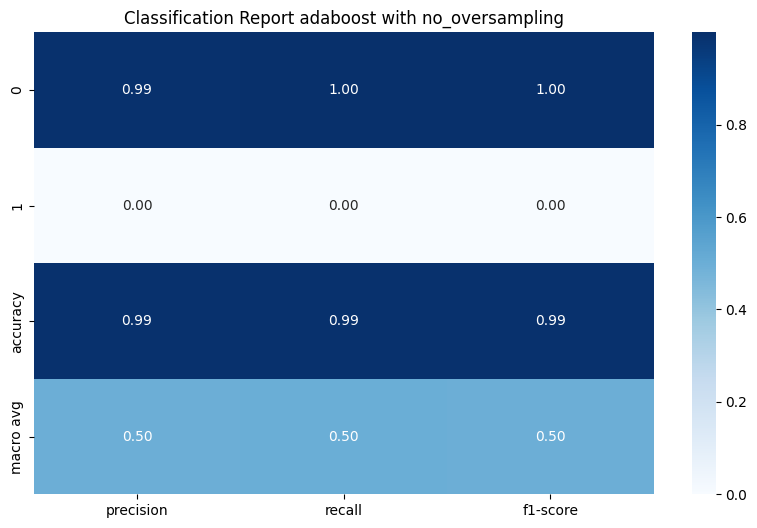

Classification Report saved to cl_report_adaboost_smote.json


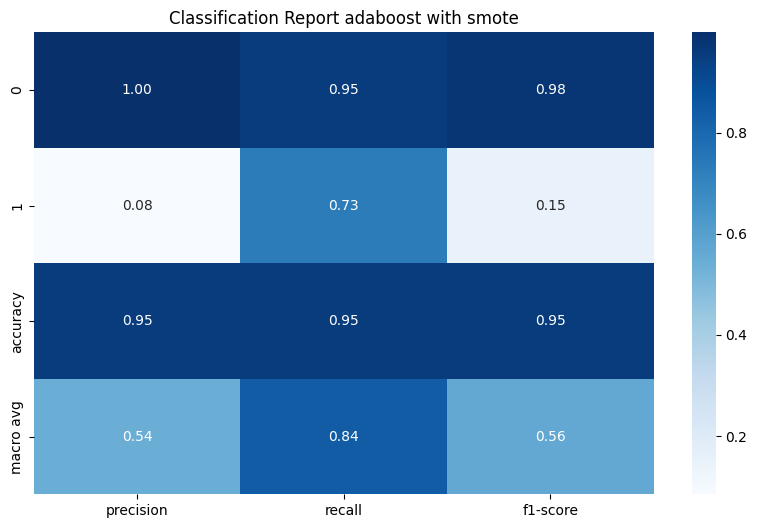

Classification Report saved to cl_report_adaboost_adasyn.json


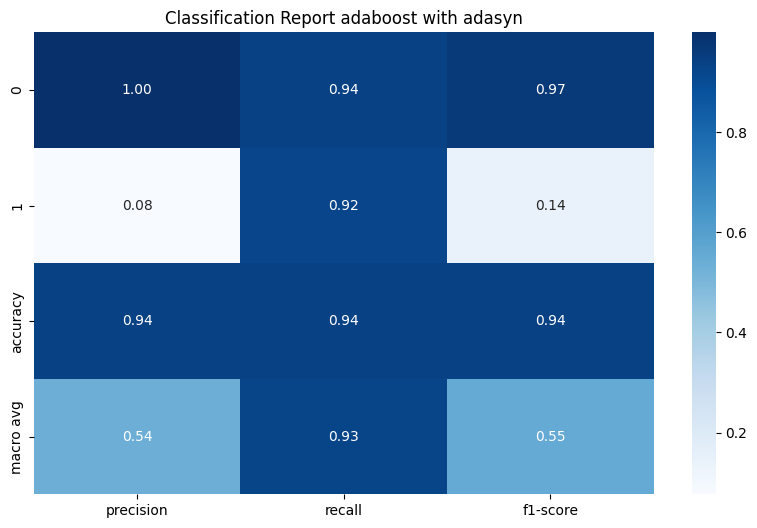

Classification Report saved to cl_report_random_forest_no_oversampling.json


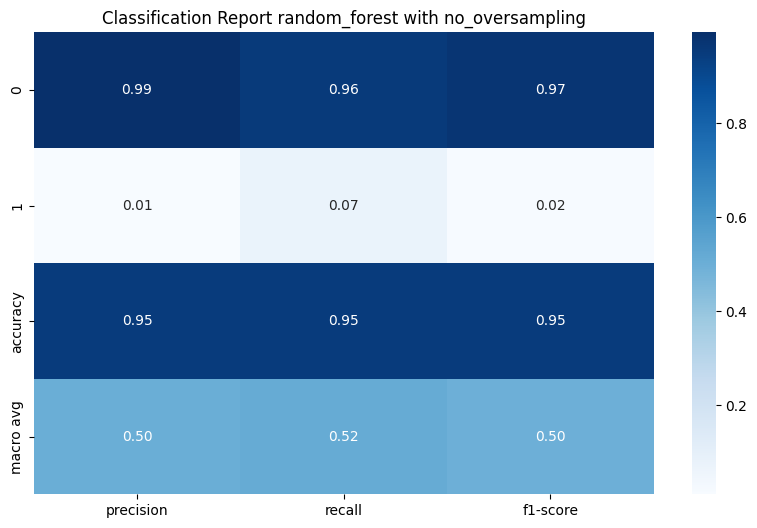

Classification Report saved to cl_report_random_forest_smote.json


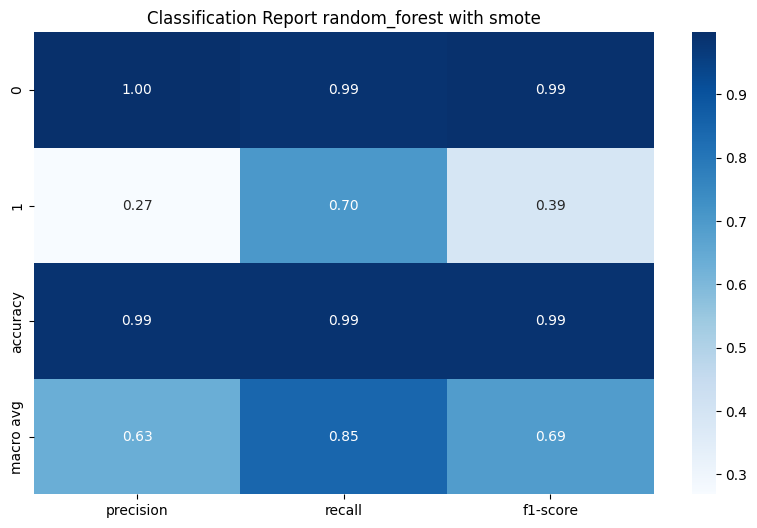

Classification Report saved to cl_report_random_forest_adasyn.json


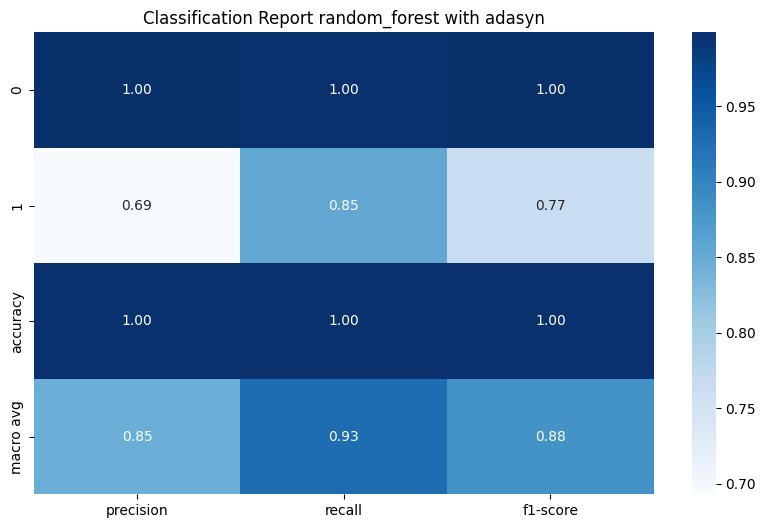

Classification Report saved to cl_report_decision_tree_no_oversampling.json


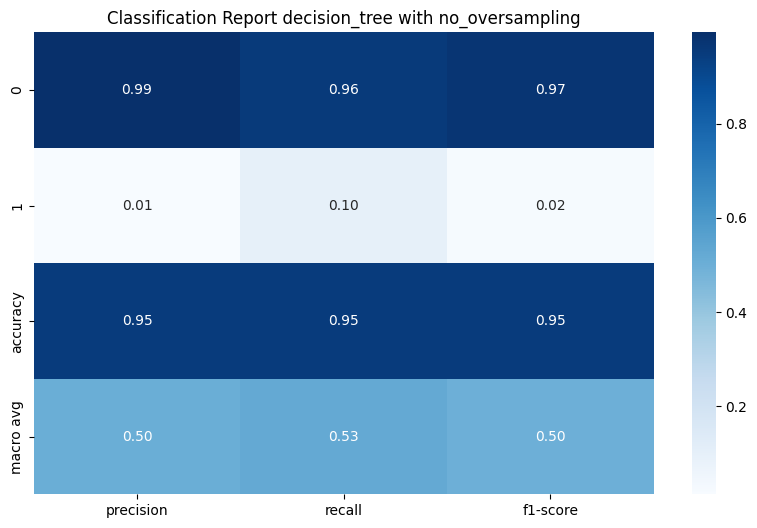

Classification Report saved to cl_report_decision_tree_smote.json


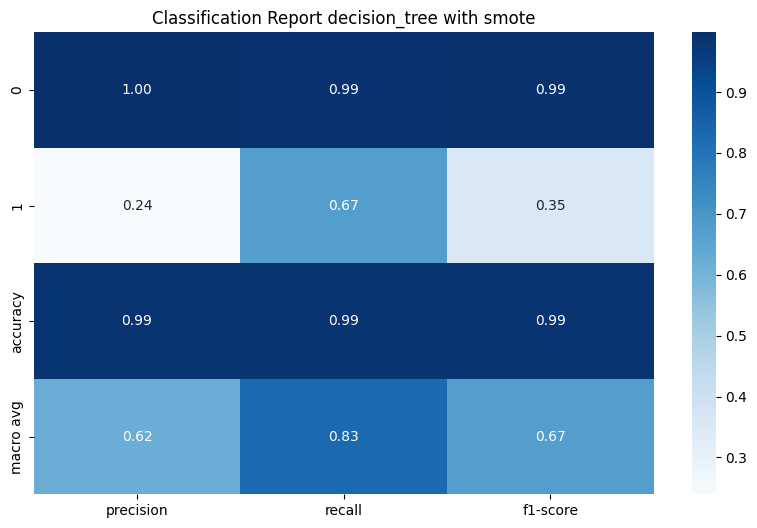

Classification Report saved to cl_report_decision_tree_adasyn.json


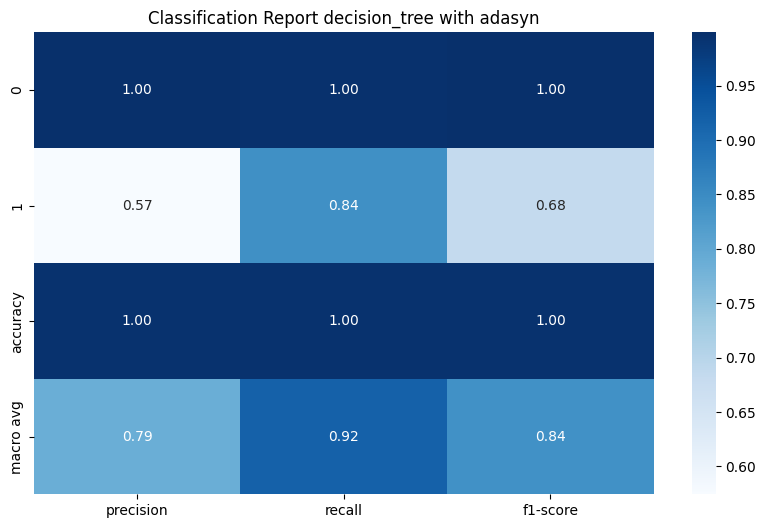

Classification Report saved to cl_report_logistic_regression_no_oversampling.json


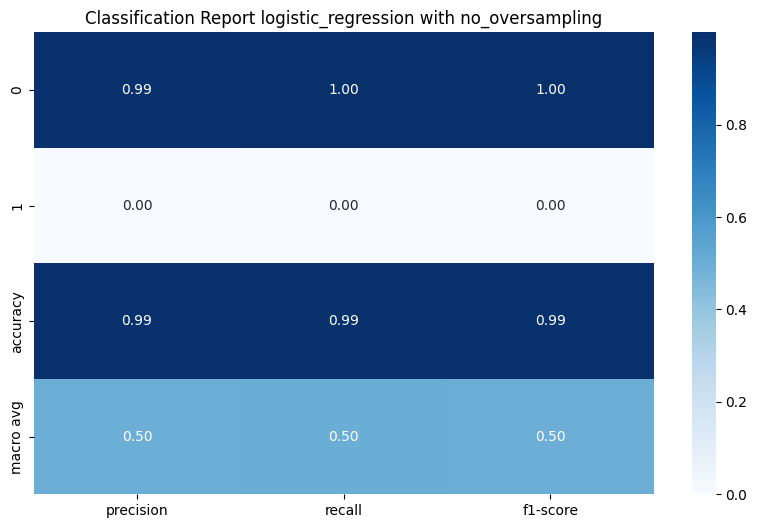

Classification Report saved to cl_report_logistic_regression_smote.json


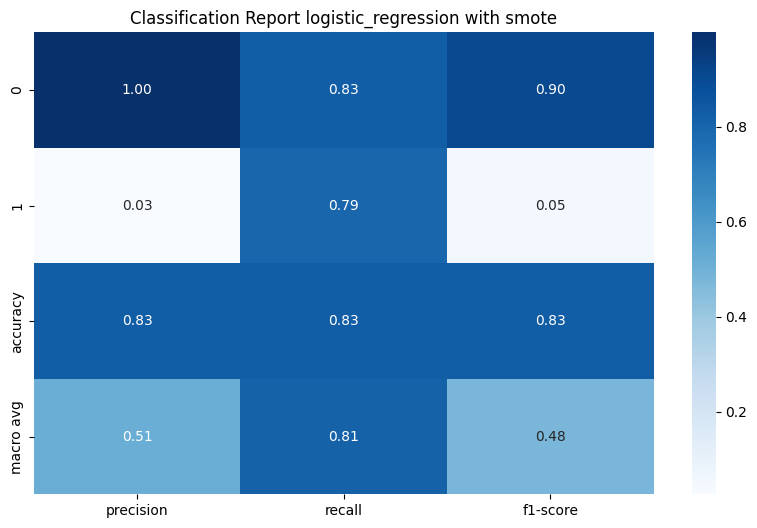

Classification Report saved to cl_report_logistic_regression_adasyn.json


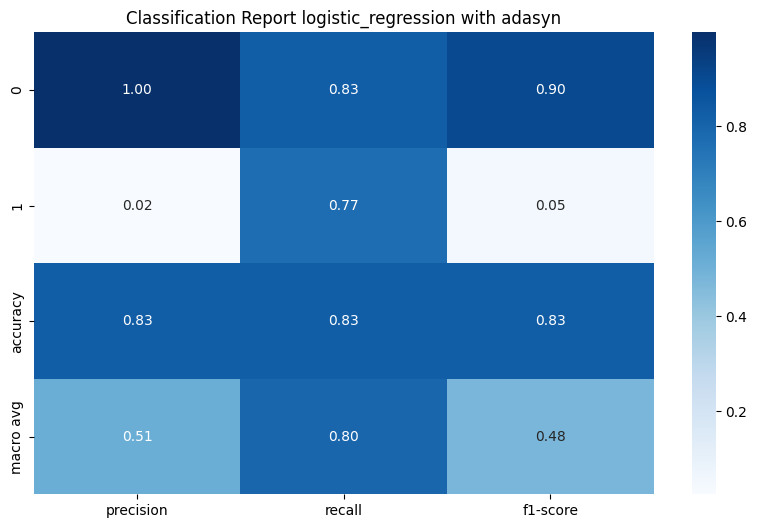

In [75]:
# show classification report
for model_name in MODEL_DICT:
    methods = MODEL_DICT[model_name]['predictions']
    MODEL_DICT[model_name]['classification_reports'] = {}
    for method in methods:
        y_pred = methods[method]
        cl_report = classification_report(y_test, y_pred, output_dict=True)
        save_report_to_json(cl_report, f"cl_report_{model_name}_{method}.json")
        cl_report_df = pd.DataFrame(cl_report).transpose()
        MODEL_DICT[model_name]['classification_reports'][method] = cl_report

        # Visualisasi laporan klasifikasi
        plt.figure(figsize=(10,6))
        sns.heatmap(cl_report_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt='.2f')
        plt.title(f"Classification Report {model_name} with {method}")
        plt.savefig(f"classification_report_{model_name}_{method}")
        plt.show()


In [76]:
# show accuracy scores
for model_name in MODEL_DICT:
    methods = MODEL_DICT[model_name]['predictions']
    MODEL_DICT[model_name]['accuracy_scores'] = {}
    for method in methods:
        y_pred = methods[method]
        acc_score = accuracy_score(y_test, y_pred)
        MODEL_DICT[model_name]['accuracy_scores'][method] = acc_score
        print(f"Accuracy {model_name} with {method}: ", acc_score)


Accuracy adaboost with no_oversampling:  0.9940848785227877
Accuracy adaboost with smote:  0.952815273918196
Accuracy adaboost with adasyn:  0.9352190085937641
Accuracy random_forest with no_oversampling:  0.9504271175286566
Accuracy random_forest with smote:  0.9871800474546468
Accuracy random_forest with adasyn:  0.9969666043706604
Accuracy decision_tree with no_oversampling:  0.9507895825996201
Accuracy decision_tree with smote:  0.985745611216366
Accuracy decision_tree with adasyn:  0.99547304262435
Accuracy logistic_regression with no_oversampling:  0.9940771665000013
Accuracy logistic_regression with smote:  0.82585224278476
Accuracy logistic_regression with adasyn:  0.8251041765744738


In [77]:
# Create a dictionary with the data
data_scores = {
    'Model': [],
    'Oversampling Method': [],
    'Accuracy Score': []
}

for model_name in MODEL_DICT:
    methods = MODEL_DICT[model_name]['accuracy_scores']
    for method in methods:
        acc_scores = methods[method]
        data_scores['Model'].append(model_name)
        data_scores['Oversampling Method'].append(method)
        data_scores['Accuracy Score'].append(acc_scores)

# Convert the dictionary to a DataFrame
accuracy_df = pd.DataFrame(data_scores)
accuracy_df

,Model,Oversampling Method,Accuracy Score
0,adaboost,no_oversampling,0.994085
1,adaboost,smote,0.952815
2,adaboost,adasyn,0.935219
3,random_forest,no_oversampling,0.950427
4,random_forest,smote,0.987180
5,random_forest,adasyn,0.996967
6,decision_tree,no_oversampling,0.950790
7,decision_tree,smote,0.985746
8,decision_tree,adasyn,0.995473
9,logistic_regression,no_oversampling,0.994077


In [78]:
accuracy_df.to_csv('accuracy_scores.csv', index=False)

In [79]:
data_cl_report = {}

for model_name in MODEL_DICT:
    methods = MODEL_DICT[model_name]['classification_reports']
    for method in methods:
        cl_report = methods[method]
        data_cl_report[f"{model_name}_{method}"] = cl_report

# Mengubah hasil evaluasi menjadi pandas DataFrame
data_cl_report_df = pd.DataFrame.from_dict({
    (model, metric): values 
    for model, metrics in data_cl_report.items() 
    for metric, values in metrics.items() if metric != 'accuracy'
}, orient='index')

data_cl_report_df

precision    recall  \
adaboost_no_oversampling            0              0.994210  0.999873   
                                    1              0.000000  0.000000   
                                    macro avg      0.497105  0.499937   
                                    weighted avg   0.988454  0.994085   
adaboost_smote                      0              0.998360  0.954107   
                                    1              0.084867  0.730906   
                                    macro avg      0.541614  0.842507   
                                    weighted avg   0.993072  0.952815   
adaboost_adasyn                     0              0.999527  0.935284   
                                    1              0.076761  0.924067   
                                    macro avg      0.538144  0.929676   
                                    weighted avg   0.994185  0.935219   
random_forest_no_oversampling       0              0.994392  0.955527   
                                    1              0.009673  0.074600   
                                    macro avg      0.502033  0.515064   
                                    weighted avg   0.988692  0.950427   
random_forest_smote                 0              0.998259  0.988830   
                                    1              0.268417  0.703819   
                                    macro avg      0.633338  0.846324   
                                    weighted avg   0.994034  0.987180   
random_forest_adasyn                0              0.999153  0.997794   
                                    1              0.692945  0.854796   
                                    macro avg      0.846049  0.926295   
                                    weighted avg   0.997381  0.996967   
decision_tree_no_oversampling       0              0.994530  0.955760   
                                    1              0.012638  0.097247   
                                    macro avg      0.503584  0.526503   
                                    weighted avg   0.988846  0.950790   
decision_tree_smote                 0              0.998072  0.987571   
                                    1              0.239519  0.672291   
                                    macro avg      0.618795  0.829931   
                                    weighted avg   0.993680  0.985746   
decision_tree_adasyn                0              0.999077  0.996367   
                                    1              0.574371  0.841918   
                                    macro avg      0.786724  0.919143   
                                    weighted avg   0.996618  0.995473   
logistic_regression_no_oversampling 0              0.994210  0.999866   
                                    1              0.000000  0.000000   
                                    macro avg      0.497105  0.499933   
                                    weighted avg   0.988454  0.994077   
logistic_regression_smote           0              0.998553  0.826035   
                                    1              0.025901  0.794405   
                                    macro avg      0.512227  0.810220   
                                    weighted avg   0.992922  0.825852   
logistic_regression_adasyn          0              0.998364  0.825438   
                                    1              0.024971  0.767762   
                                    macro avg      0.511668  0.796600   
                                    weighted avg   0.992729  0.825104   

                                                  f1-score   support  
adaboost_no_oversampling            0             0.997034  386751.0  
                                    1             0.000000    2252.0  
                                    macro avg     0.498517  389003.0  
                                    weighted avg  0.991262  389003.0  
adaboost_smote                      0             0.975732  386751.0  
                                    1         

In [80]:
data_cl_report_df.to_csv('classification_report.csv', index=False)

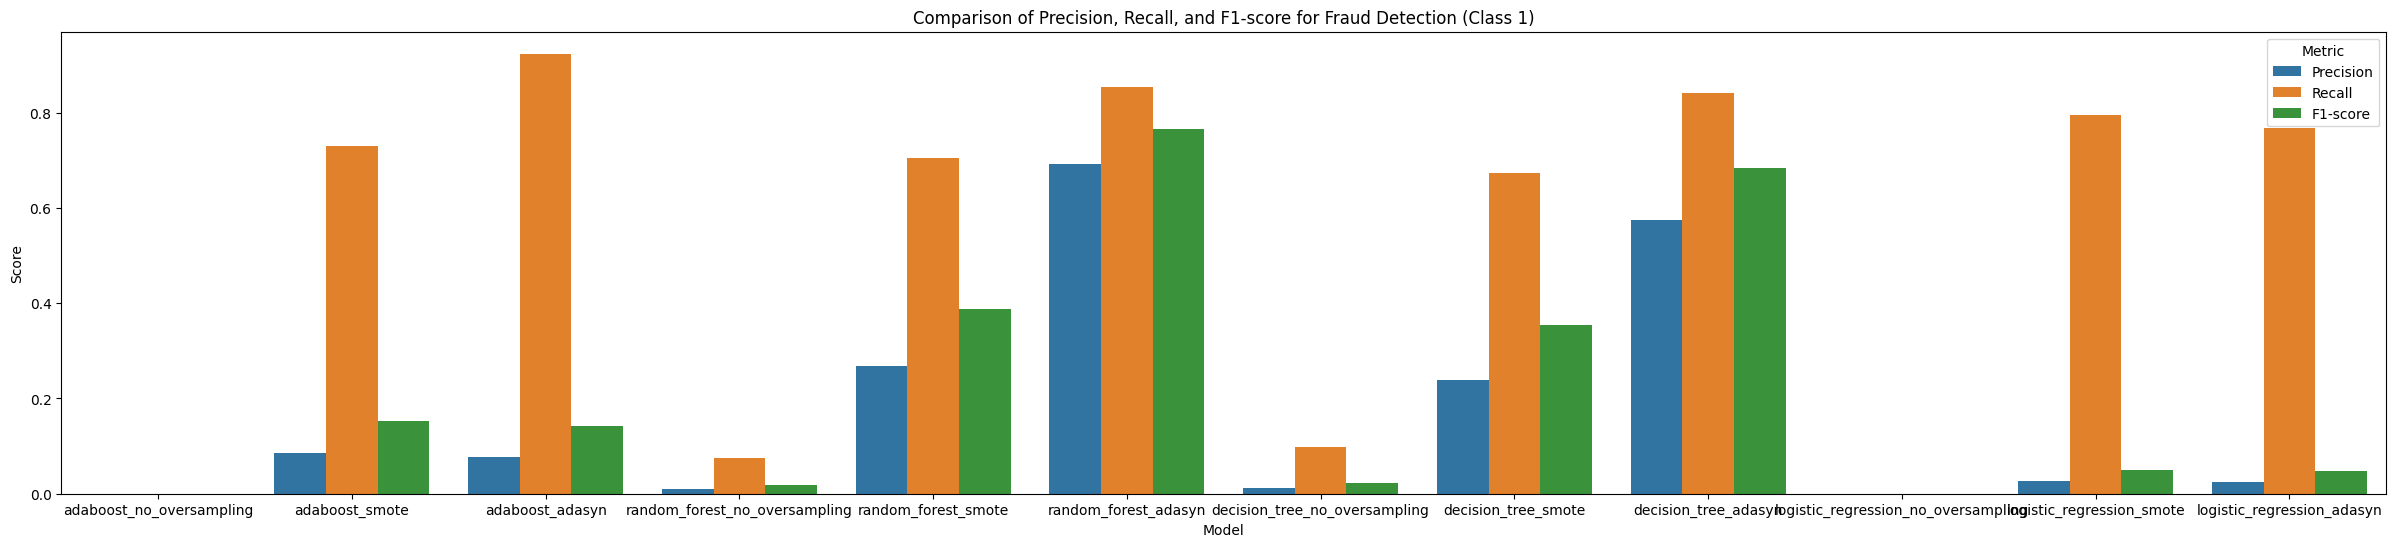

In [83]:
# Mengambil data untuk precision, recall, dan f1-score dari kelas fraud (1)
precision_1 = {model: metrics['1']['precision'] for model, metrics in data_cl_report.items()}
recall_1 = {model: metrics['1']['recall'] for model, metrics in data_cl_report.items()}
f1_score_1 = {model: metrics['1']['f1-score'] for model, metrics in data_cl_report.items()}

# Membuat DataFrame untuk visualisasi
df_plot_class_1 = pd.DataFrame({
    'Model': list(precision_1.keys()),
    'Precision': list(precision_1.values()),
    'Recall': list(recall_1.values()),
    'F1-score': list(f1_score_1.values())
})

# Plot menggunakan seaborn
df_plot_class_1_melt = df_plot_class_1.melt('Model', var_name='Metric', value_name='Score')
plt.figure(figsize=(30, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=df_plot_class_1_melt)
plt.title('Comparison of Precision, Recall, and F1-score for Fraud Detection (Class 1)')
plt.savefig('comparison_report_class_1')
plt.show()

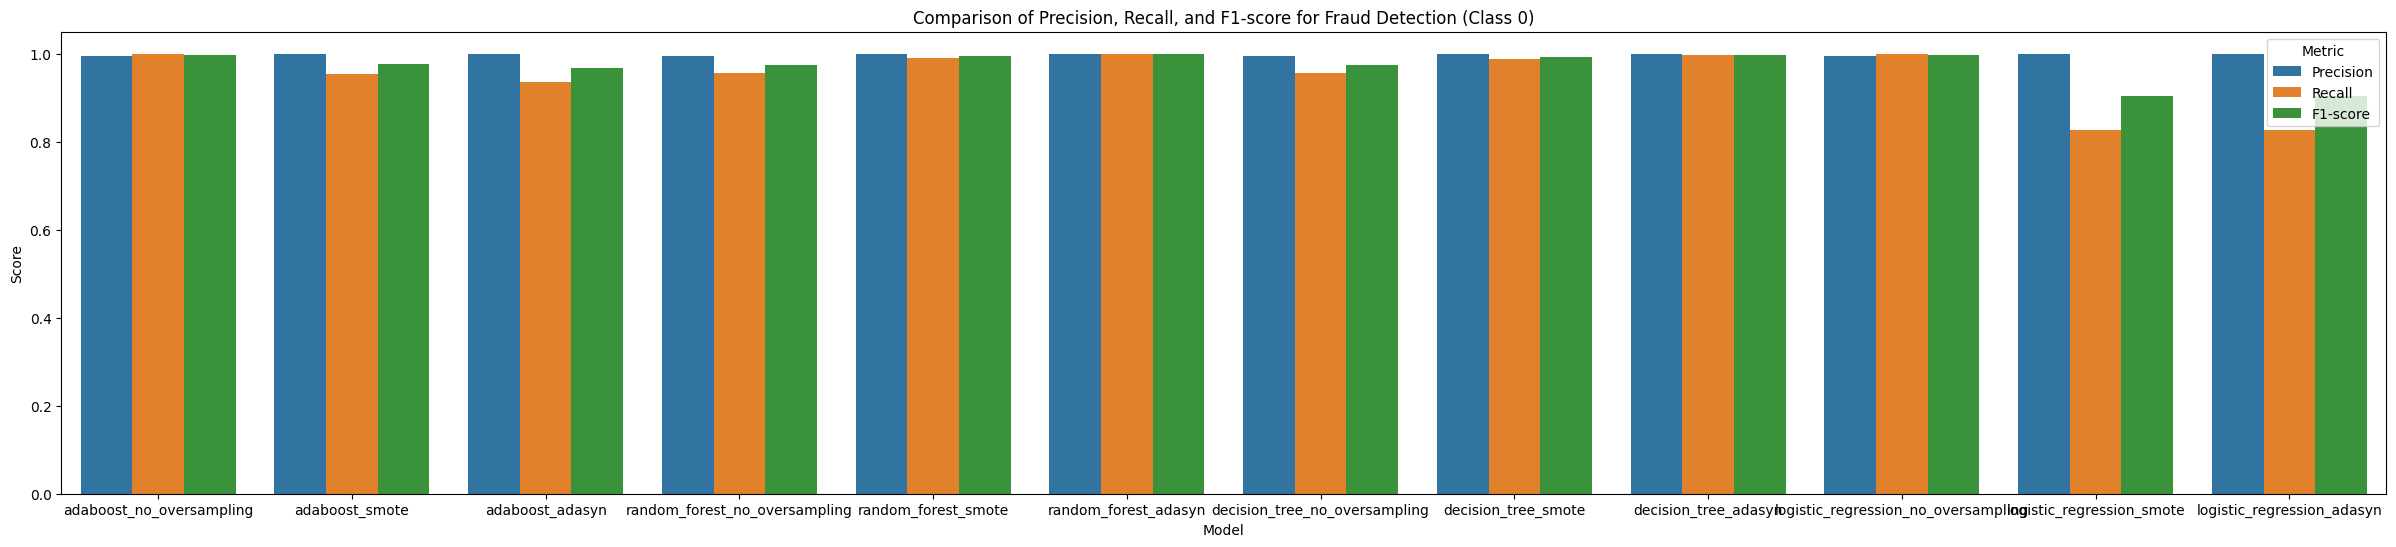

In [84]:
# Mengambil data untuk precision, recall, dan f1-score dari kelas non-fraud (0)
precision_0 = {model: metrics['0']['precision'] for model, metrics in data_cl_report.items()}
recall_0 = {model: metrics['0']['recall'] for model, metrics in data_cl_report.items()}
f1_score_0 = {model: metrics['0']['f1-score'] for model, metrics in data_cl_report.items()}

# Membuat DataFrame untuk visualisasi
df_plot_class_0 = pd.DataFrame({
    'Model': list(precision_0.keys()),
    'Precision': list(precision_0.values()),
    'Recall': list(recall_0.values()),
    'F1-score': list(f1_score_0.values())
})

# Plot menggunakan seaborn
df_plot_class_0_melt = df_plot_class_0.melt('Model', var_name='Metric', value_name='Score')
plt.figure(figsize=(30, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=df_plot_class_0_melt)
plt.title('Comparison of Precision, Recall, and F1-score for Fraud Detection (Class 0)')
plt.savefig('comparison_report_class_0')
plt.show()